# 8장. 이미지를 분류합니다

이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/do-it-dl/blob/master/Ch08.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/do-it-dl/blob/master/Ch08.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

이 노트북을 실행하려면 텐서플로 2.0.0-alpha0 버전 이상이 필요합니다.

## 08-1 합성곱을 알아 봅니다.

In [2]:
import numpy as np

In [2]:
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [3]:
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


In [4]:
w[0:4:2]

array([2, 5])

In [5]:
for i in range(6):
    print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [3]:
from scipy.signal import convolve

In [7]:
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [4]:
from scipy.signal import correlate

In [9]:
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [10]:
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [11]:
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [5]:
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])

In [6]:
from scipy.signal import correlate2d

correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [14]:
np.flip(w)

array([[0, 0],
       [0, 2]])

In [7]:
from scipy.signal import convolve2d

convolve2d(x, w, mode='valid')

array([[10, 12],
       [16, 18]])

In [16]:
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [8]:
import tensorflow as tf

In [10]:
x_4d = x.astype(float).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)

In [11]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')
c_out.numpy().reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

## 08-2 풀링에 대해서 알아 봅니다

In [20]:
x = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

In [21]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

## 08-3 합성곱 신경망의 구조를 알아 봅니다

In [22]:
def relu(x):
    return np.maximum(x, 0)

In [23]:
x = np.array([-1, 2, -3, 4, -5])

relu(x)

array([0, 2, 0, 4, 0])

In [24]:
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

## 08-4 합성곱 신경망을 만듭니다.

In [12]:
import tensorflow as tf

class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수
        self.kernel_size = 3        # 커널 크기
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다.
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 활성화 함수를 적용합니다.
        r_out = tf.nn.relu(c_out)
        # 2x2 최대 풀링을 적용합니다.
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))
   
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [13]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
    y = x ** 3 + 2 * x + 5

# 그래디언트를 계산합니
print(tape.gradient(y, x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


In [14]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
    y = tf.nn.softmax(x)

# 그래디언트를 계산합니다.
print(tape.gradient(y, x))

tf.Tensor([1.99908031e-17 5.43406367e-17 1.47713165e-16], shape=(3,), dtype=float64)


In [19]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [22]:
x_train.shape

(48000, 28, 28)

In [17]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [23]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [24]:
x_train.shape

(48000, 28, 28, 1)

In [25]:
x_train = x_train / 255
x_val = x_val / 255

In [26]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

In [27]:
import matplotlib.pyplot as plt

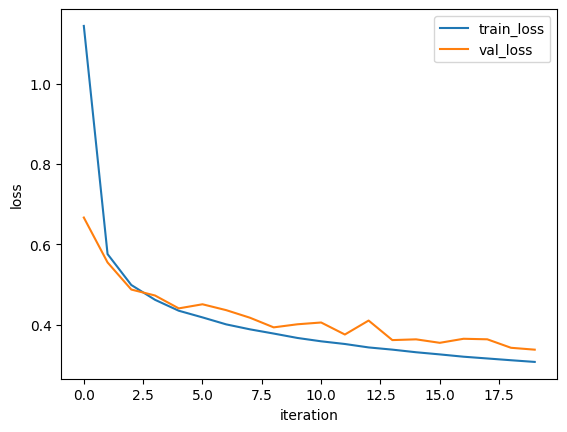

In [28]:
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [37]:
cn.score(x_val, y_val_encoded)

0.8745833333333334

## 08-5 케라스로 합성곱 신경망 모델을 만듭니다.

In [33]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [39]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv1.add(MaxPooling2D((2, 2)))
conv1.add(Flatten())
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))

In [40]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [41]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4359 - accuracy: 0.8482 - val_loss: 0.3272 - val_accuracy: 0.8832
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2964 - accuracy: 0.8919 - val_loss: 0.2807 - val_accuracy: 0.8992
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2556 - accuracy: 0.9076 - val_loss: 0.2605 - val_accuracy: 0.9043
Epoch 4/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2269 - accuracy: 0.9162 - val_loss: 0.2555 - val_accuracy: 0.9064
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2061 - accuracy: 0.9238 - val_loss: 0.2682 - val_accuracy: 0.9051
Epoch 6/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1851 - accuracy: 0.9315 - val_loss: 0.2357 - val_accuracy: 0.9176
Epoch 7/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1678 - accuracy: 0.9381 - val_loss: 0.2510 - val_accuracy:

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

NameError: name 'history' is not defined

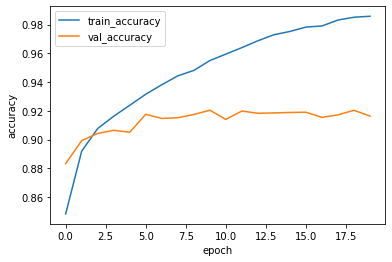

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [45]:
loss, accuracy = conv1.evaluate(x_val, y_val_encoded, verbose=0)

In [46]:
print(accuracy)

0.9163333177566528


In [34]:
from tensorflow.keras.layers import Dropout

In [35]:
conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [36]:
conv2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       196,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,210 (770.35 KB)

 Trainable params: 197,210 (770.35 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
history = conv2.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7598 - loss: 0.6669 - val_accuracy: 0.8708 - val_loss: 0.3583
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8578 - loss: 0.3915 - val_accuracy: 0.8863 - val_loss: 0.3154
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8746 - loss: 0.3430 - val_accuracy: 0.8975 - val_loss: 0.2858
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8871 - loss: 0.3112 - val_accuracy: 0.9026 - val_loss: 0.2693
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8901 - loss: 0.2887 - val_accuracy: 0.9016 - val_loss: 0.2678
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8982 - loss: 0.2723 - val_accuracy: 0.9073 - val_loss: 0.2526
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9043 - loss: 0.2545 - val_accuracy: 0.9092 - val_loss: 0.2489
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9061 - loss: 0.2500 - 

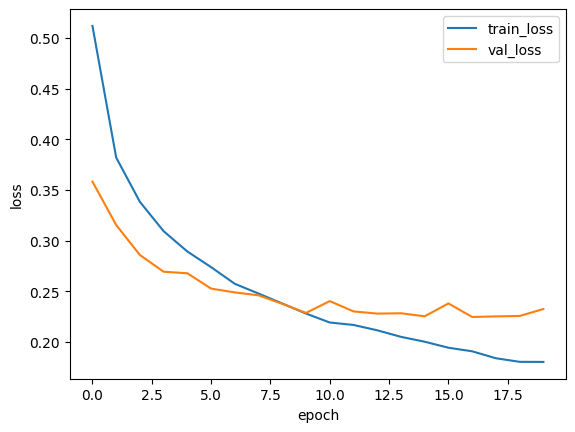

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

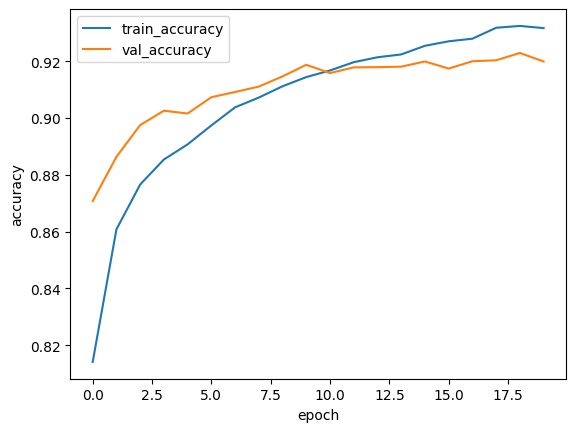

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [42]:
loss, accuracy = conv2.evaluate(x_val, y_val_encoded, verbose=0)

In [43]:
print(accuracy)

0.9199166893959045
